Memory consumption benchmark
----

In this notebook, we plot the multi-core memory performance, as well as produce Suppl. Tab. 2.

# Preliminaries

## Dependencies

1. Please consult the [analysis_files/README.md](analysis_files/README.md) on how to run the memory performance benchmarks.

## Import packages

In [1]:
# import standard packages
from pathlib import Path
from collections import defaultdict
import os
import sys
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Set up paths

In [2]:
sys.path.insert(0, "../..")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

## Set global parameters

In [3]:
root = DATA_DIR / 'benchmarking' / 'memory_analysis'
alg = "algorithm"

pretty_names = {
    'fateid': 'FateID (fate probs.)',
    'stemnet': 'STEMNET (fate probs.)',
    'palantir': 'Palantir (fate probs.)',
    'ap': 'CellRank (fate probs.)',
    'macro': 'CellRank (initial/terminal)',
    'run_markov': 'Velocyto (initial/terminal)',
}

save_figure = True

## Load the data

In [4]:
res = {
    'fateid': defaultdict(dict),
    'ap': defaultdict(dict),
    'macro': defaultdict(dict),
    'palantir': defaultdict(dict),
    'stemnet': defaultdict(dict),
    'kernel': defaultdict(dict),
    'estimate_transition_probability': defaultdict(dict),
    'calculate_embedding_shift': defaultdict(dict),
    'prepare_markov': defaultdict(dict),
    'run_markov': defaultdict(dict),
}
velo_cats = ['estimate_transition_probability', 'calculate_embedding_shift',
             'prepare_markov', 'run_markov']

for key in ['fateid', 'gpcca', 'palantir', 'stemnet', 'velocyto']:
    for fname in os.listdir(root / key):
        if not fname.endswith('.txt') and not fname.endswith('.pickle'):
            continue
        name = fname.split('.')[0]
        rest = name.split('_')
        if len(rest) == 3:
            rest = rest[1:]
            
        size, split = map(int, rest)
        path = root / key / fname
                
        if fname.endswith('.pickle'):
            with open(path, 'rb') as fin:
                data = pickle.load(fin)
                if 'ap_mem' in data:  # CellRank
                    assert key == 'gpcca'
                    res['kernel'][size][split] = max(data['kernel_mem'])
                    res['macro'][size][split] = max(data['macro_mem'])
                    res['ap'][size][split] = max(data['ap_mem'])
                elif "run_markov" in data:  # Velocyto
                    for k in velo_cats:
                        res[k][size][split] = max(data[k])
                else:
                    assert key != 'gpcca'  # anything else
                    res[key][size][split] = max(data)
        else:
            with open(path, 'r') as fin:
                data = fin.read().strip().split('\n')[-1]
                res[key][size][split] = float(data.split(' ')[-1])

### Clean the data

In [5]:
dfs = []
for key in res.keys():
    df = pd.DataFrame(res[key])
    df.sort_index(axis=0, inplace=True)
    df.sort_index(axis=1, inplace=True)
    df['algorithm'] = key
    dfs.append(df)
    
df = pd.concat(dfs, axis=0)

### Maximum memory for CellRank macrostates

In [6]:
km = pd.DataFrame(
    np.max([df[df[alg] == name].select_dtypes(exclude='category').values
            for name in ['macro', 'kernel']], axis=0), columns=df.columns
)
km['algorithm'] = 'macro'

df = df[df[alg] != 'kernel']
df[df[alg] == "macro"] = km.values

### Maximum memory for Velocyto

In [7]:
vm = pd.DataFrame(
    np.max([df[df[alg] == name].select_dtypes(exclude='category').values
            for name in velo_cats], axis=0), columns=df.columns
)

vm['algorithm'] = 'run_markov'

df = df[~np.isin(df[alg], list(set(velo_cats) - {'run_markov'}))]
df[df[alg] == "run_markov"] = vm.values

## Rename categories

In [8]:
df[alg] = df[alg].astype("category")
df[alg].cat.rename_categories(pretty_names, inplace=True)
df[alg].cat.reorder_categories([pretty_names[c] for c in
                                ['ap', 'macro', 'fateid', 'palantir', 'stemnet', 'run_markov']], inplace=True)

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


### Convert to GiB

In [9]:
tmp = df.select_dtypes(exclude='category').divide(1024)  # work in GiB instead of MiB
tmp[alg] = df[alg]
df = tmp

## Show the resulting table

In [10]:
df

,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,algorithm
0,2.546875,9.995703,18.478613,34.937598,52.908105,74.603906,96.169336,124.579785,155.448926,NaN,FateID (fate probs.)
1,2.543652,10.012305,18.499707,34.933203,52.912793,71.765332,99.785449,124.610742,149.610547,NaN,FateID (fate probs.)
2,2.545508,10.008691,18.503223,34.910645,52.901758,71.855078,100.024316,128.125293,156.439258,NaN,FateID (fate probs.)
3,2.547559,10.010449,18.503711,34.905371,52.911816,74.246289,100.044531,122.123926,155.517480,NaN,FateID (fate probs.)
4,2.542578,8.055762,18.498633,34.903418,52.497461,69.254590,97.660938,125.328516,157.385059,NaN,FateID (fate probs.)
5,2.548047,10.009961,18.499316,34.896191,52.862988,74.674316,99.302539,124.271191,159.361133,NaN,FateID (fate probs.)
6,2.542578,10.012598,18.501562,34.529883,52.534961,73.953223,99.826465,125.832617,150.316797,NaN,FateID (fate probs.)
7,2.543164,10.001074,18.496582,34.902637,52.936914,74.673242,99.693164,123.488965,155.308887,NaN,FateID (fate probs.)
8,2.546875,9.998340,18.480957,34.927051,52.897266,74.619727,98.147559,126.562402,154.169434,NaN,FateID (fate probs.)
9,2.548242,10.009570,18.500098,34.942285,51.855664,74.625684,98.507324,121.618457,157.422461,NaN,FateID (fate probs.)


## Define utility functions

In [11]:
def plot(df):

    tmp = pd.melt(df, id_vars=[alg], var_name='size', value_name='memory')
    tmp[alg] = tmp[alg].astype('category')
    tmp["memory"] = tmp["memory"].astype(np.float64)
    
    fig, ax = plt.subplots(figsize=(6, 4), dpi=400)
    colors = [sns.palettes.color_palette('colorblind')[i] for i in range(len(tmp[alg].cat.categories))]
    colors[-1] = sns.palettes.color_palette('colorblind')[len(tmp[alg].cat.categories) + 3]
    
    flierprops = dict(marker='o', markersize=2, markerfacecolor='none', linestyle='none')
    
    sns.boxplot(x='size', y='memory', hue=alg, data=tmp, ax=ax, width=0.25,
                saturation=1,
                dodge=False,
                flierprops=flierprops,
                linewidth=1,
                palette=colors)
            
    data = tmp.groupby(["algorithm", "size"]).median()
    for i, cat in enumerate(tmp[alg].cat.categories):
        med = data.loc[cat].values.squeeze()
        med = med[med == med]
        ax.plot(np.arange(len(med)), med, c=colors[i], zorder=-1, ls='--', lw=1.25)
        
    ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    
    ax.set_title("comparison of peak memory usage")
    ax.set_xlabel('number of cells in thousands')
    ax.set_xticklabels(np.linspace(10, 100, num=10, dtype='int'))
    ax.set_ylabel('memory (GiB)')
    ax.margins(0.025)
    
    fig.show()
    
    return fig

# Plot the results

<ipython-input-11-08c3d20bd990>:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


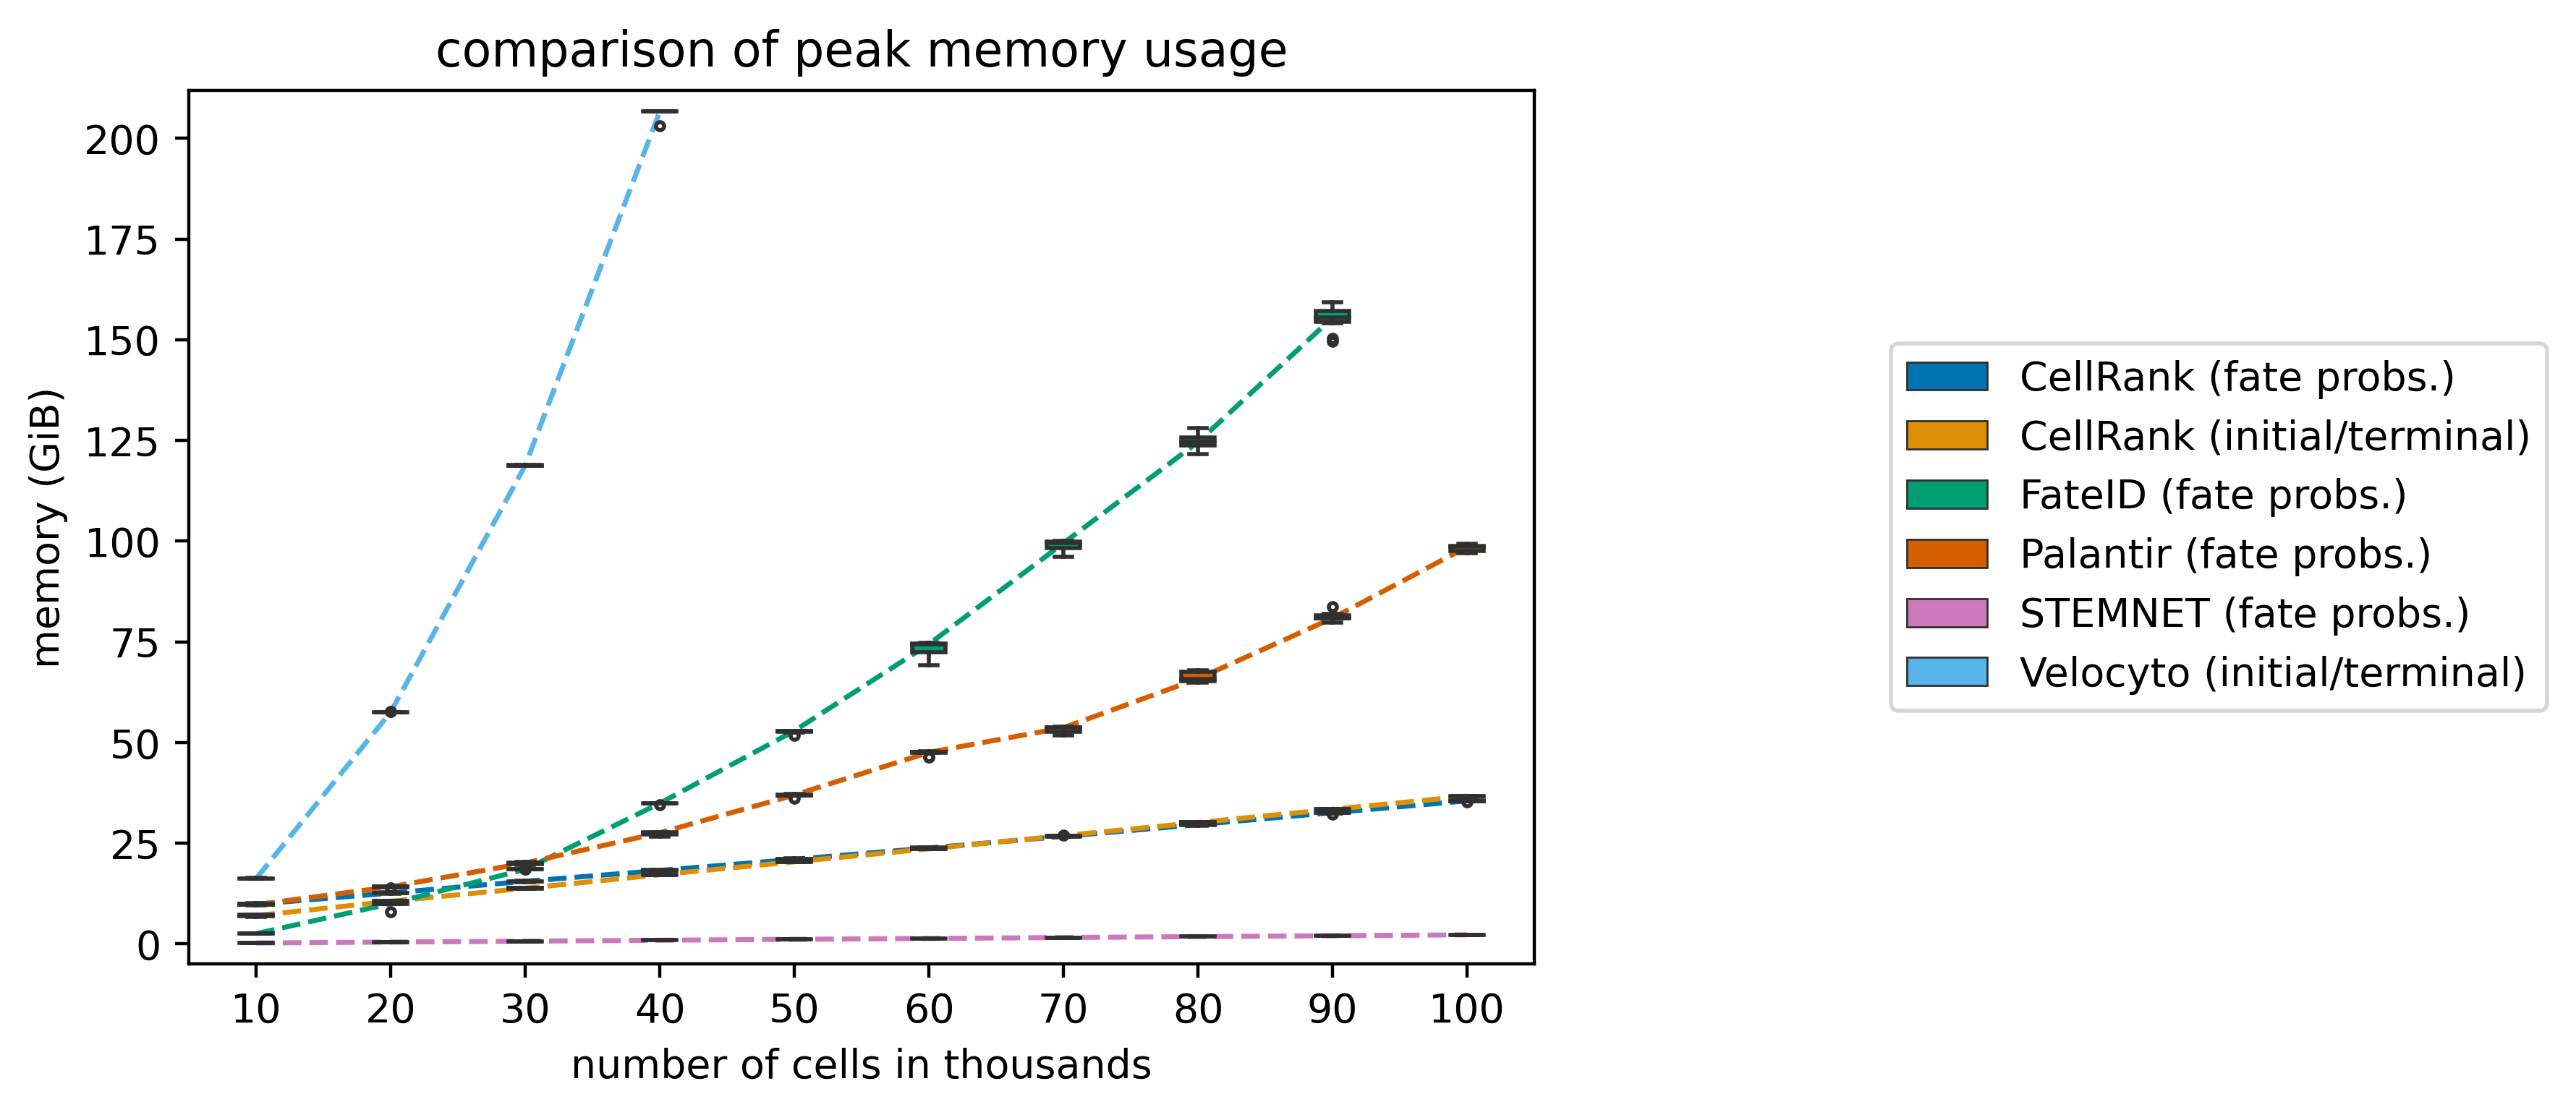

In [16]:
fig = plot(df)
if save_figure:
    fig.savefig(FIG_DIR / "fig_5_benchmarking" / "memory_benchmark.pdf", bbox_inches='tight', transparent=True)

## Extract the data for the table creation

In [13]:
mean = df.groupby(alg).mean().T
mean.index.name = 'size'
mean.columns = [f"{c} mean" for c in mean.columns]

std = df.groupby(alg).std().T
std.index.name = 'size'
std.columns = [f"{c} std" for c in std.columns]

stats = pd.concat([mean, std], axis=1)
stats.index = stats.index.astype(int)
stats.index = np.array(stats.index / 1000, dtype='int')
stats.index.name = '#cells (thousands)'
stats = stats.round(2)

### Reorder the table columns

In [14]:
order = ['CellRank (initial/terminal)', 'CellRank (fate probs.)', 'STEMNET (fate probs.)',
         'Palantir (fate probs.)', 'FateID (fate probs.)', "Velocyto (initial/terminal)"]
stats = stats[[f"{c} {s}" for c in order for s in ('mean', 'std')]]
stats

,CellRank (initial/terminal) mean,CellRank (initial/terminal) std,CellRank (fate probs.) mean,CellRank (fate probs.) std,STEMNET (fate probs.) mean,STEMNET (fate probs.) std,Palantir (fate probs.) mean,Palantir (fate probs.) std,FateID (fate probs.) mean,FateID (fate probs.) std,Velocyto (initial/terminal) mean,Velocyto (initial/terminal) std
#cells (thousands),,,,,,,,,,,,
10,7.04,0.15,9.90,0.09,0.23,0.0,9.74,0.06,2.55,0.00,16.24,0.05
20,10.59,0.01,12.64,0.10,0.46,0.0,14.15,0.09,9.81,0.62,57.58,0.04
30,13.81,0.04,15.53,0.08,0.68,0.0,20.02,0.19,18.50,0.01,118.81,0.03
40,17.18,0.02,18.26,0.07,0.91,0.0,27.43,0.34,34.88,0.12,206.32,1.13
50,20.39,0.04,21.02,0.10,1.14,0.0,36.89,0.28,52.72,0.35,NaN,NaN
60,23.61,0.03,23.83,0.09,1.36,0.0,47.38,0.55,73.43,1.85,NaN,NaN
70,26.88,0.02,26.68,0.06,1.59,0.0,53.24,0.81,98.92,1.28,NaN,NaN
80,30.14,0.02,29.63,0.13,1.81,0.0,66.28,1.20,124.65,1.96,NaN,NaN
90,33.41,0.03,32.55,0.15,2.04,0.0,81.19,1.08,155.10,3.07,NaN,NaN


## Save the table

In [15]:
stats.to_csv(DATA_DIR / "benchmarking_results" / "suppl_tab_memory_benchmark" / "statistics.csv")